In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

# Load the data

In [2]:
df_train = pd.read_csv("data/competition_data/train.csv")
df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test = pd.read_csv("data/competition_data/test.csv")

df_train

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,226050,1,0,0,F,Y,Blue,Circle,Lion,Finland,Bassoon,d372c8993,3ac1b8814,22831fffe,72221799b,a5492d7e5,1,Master,Freezing,a,I,Ed,4,12,0
1,225298,0,1,1,F,N,Green,Star,Lion,Canada,Oboe,416a8f3ab,5fd7600de,68d88988b,537d3703e,c31c67153,2,Master,Warm,k,H,wu,2,9,1
2,271011,0,0,1,T,Y,Blue,Star,Lion,China,Bassoon,84b0081ad,d42f2b9ec,03338a71c,c8f505f52,9c4213a50,2,Grandmaster,Freezing,g,W,Fd,2,6,0
3,182099,1,0,0,T,Y,Blue,Trapezoid,Hamster,China,Theremin,488406659,8f897ec3c,df0980add,6a484e7c5,98ee82a0d,3,Grandmaster,Freezing,k,R,Dc,3,12,0
4,54595,1,0,1,T,Y,Green,Polygon,Hamster,China,Oboe,91ea3e4dd,55a24a71b,daf851ceb,c68e5326c,e6517df10,3,Novice,Lava Hot,k,Z,vK,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,145723,0,0,1,F,Y,Blue,Square,Hamster,China,Piano,30a15b6bd,144279ac1,c4a8e37bb,91c3125ab,d164a98e8,1,Contributor,Lava Hot,g,U,on,1,12,1
299996,144743,0,0,1,F,N,Blue,Star,Lion,Costa Rica,Bassoon,5b0f5acd5,d95501ac1,0f6dcae96,2d10dbc79,153e91279,1,Master,Boiling Hot,a,X,BE,6,9,0
299997,13174,0,0,0,F,N,Green,Trapezoid,Cat,India,Bassoon,b0faff28f,aee98fa47,c399f2457,eb1b8cea2,e02eda5e8,1,Novice,Cold,i,R,eQ,7,3,0
299998,203078,1,0,0,F,Y,Green,Triangle,Lion,Russia,Theremin,6c90f81cd,1ea13ded7,168469b34,9177167a4,fe7e32fbb,3,Grandmaster,Warm,o,A,nh,5,2,0


In [3]:
# the rate of 1 target values 
df_train["target"].mean()

0.30588

# Decision Tree just for the binary features as benchmark

In [4]:
def process_bin_features(df, target=True):
    df_out = df.copy()[["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"]]
    df_out["bin_3"] = df_out["bin_3"].map({"T": 1, "F": 0})
    df_out["bin_4"] = df_out["bin_4"].map({"Y": 1, "N": 0})

    if target:
        y = df.copy()["target"]
        return df_out, y
    
    else:
        return df_out

df_train_bin, y_bin = process_bin_features(df_train, target=True)

y_bin1 = y_bin[:df_train_bin.shape[0] // 2]
y_bin2 = y_bin[df_train_bin.shape[0] // 2:]

df_train_bin1 = df_train_bin.copy()[:df_train_bin.shape[0] // 2]
df_train_bin2 = df_train_bin.copy()[df_train_bin.shape[0] // 2:]

display(df_train_bin1)
y_bin1

,bin_0,bin_1,bin_2,bin_3,bin_4
0,1,0,0,0,1
1,0,1,1,0,0
2,0,0,1,1,1
3,1,0,0,1,1
4,1,0,1,1,1
...,...,...,...,...,...
149995,0,0,0,0,0
149996,0,0,1,1,1
149997,0,1,1,1,0
149998,0,0,1,0,1


0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: target, Length: 150000, dtype: int64

In [5]:
# fit a decition tree
model_tree = DecisionTreeClassifier(
    criterion="entropy",
    min_samples_leaf = 1
)

model_tree = model_tree.fit(df_train_bin1, y_bin1)

In [6]:
y_bin1.sum()

45932

In [7]:
pred_bin1 = model_tree.predict_proba(df_train_bin1)
pred_bin2 = model_tree.predict_proba(df_train_bin2)

pred_bin1

array([[0.68455882, 0.31544118],
       [0.74249674, 0.25750326],
       [0.67943732, 0.32056268],
       ...,
       [0.72066327, 0.27933673],
       [0.6779807 , 0.3220193 ],
       [0.59795918, 0.40204082]])

In [8]:
# score
y_score_train_bin1 = [s[1] for s in pred_bin1]
y_score_train_bin2 = [s[1] for s in pred_bin2]

print(f"""
    Score on training set: {roc_auc_score(y_true=y_bin1, y_score=y_score_train_bin1)}
    Score on test set: {roc_auc_score(y_true=y_bin2, y_score=y_score_train_bin2)}
""")


    Score on training set: 0.5604617456521664
    Score on test set: 0.55961071252835



In [9]:
# make submission
df_test_bin = process_bin_features(df_test, target=False)

df_test_bin

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0,0,1,1,1
1,0,0,0,1,0
2,1,0,1,0,1
3,0,0,1,1,1
4,0,1,1,0,0
...,...,...,...,...,...
199995,0,0,0,0,0
199996,1,0,0,0,1
199997,0,1,1,1,1
199998,1,0,0,1,1


In [10]:
submission = pd.read_csv("data/competition_data/sample_submission.csv")

submission

,id,target
0,300000,0.5
1,300001,0.5
2,300002,0.5
3,300003,0.5
4,300004,0.5
...,...,...
199995,499995,0.5
199996,499996,0.5
199997,499997,0.5
199998,499998,0.5


In [11]:
model_sub = DecisionTreeClassifier(
    criterion="entropy",
    min_samples_leaf = 1
)

# fit on full training set
df_train_bin, y = process_bin_features(df_train, target=True)

model_sub = model_sub.fit(df_train_bin, y)

y_submission = [s[1] for s in model_sub.predict_proba(df_test_bin)]

submission["target"] = y_submission

submission

,id,target
0,300000,0.313906
1,300001,0.345002
2,300002,0.339578
3,300003,0.313906
4,300004,0.257908
...,...,...
199995,499995,0.359714
199996,499996,0.325123
199997,499997,0.227130
199998,499998,0.300739


In [12]:
submission.to_csv("data/submissions/decision_tree_on_binary.csv", header=True, index=False)

In [13]:
"""kaggle score: ~ .558"""

'kaggle score: ~ .558'

# Trying a decision tree using all data

In [21]:
y_train = df_train["target"]

y_train

0         0
1         1
2         0
3         0
4         1
         ..
299995    1
299996    0
299997    0
299998    0
299999    0
Name: target, Length: 300000, dtype: int64

In [15]:
def process_features(df):
    df_out = df.copy()
    
    # binary features to 0, 1
    df_out["bin_3"] = df_out["bin_3"].map({"T": 1, "F": 0})
    df_out["bin_4"] = df_out["bin_4"].map({"Y": 1, "N": 0})

    # ordinal features to int
    for field in ["ord_1", "ord_2", "ord_3", "ord_4", "ord_5"]:
        df[field] = pd.Categorical(df[field])
        df_out[field] = df[field].cat.codes
        
    # nominal features to int (same as for ordinal, but let's separate to keep us some options)
    for field in ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
        df[field] = pd.Categorical(df[field])
        df_out[field] = df[field].cat.codes
        
    return df_out


df_train_processed = process_features(df_train)

df_train_processed

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,226050,1,0,0,0,1,0,0,4,3,0,178,120,146,1006,7640,1,3,2,0,8,17,4,12,0
1,225298,0,1,1,0,0,1,3,4,0,1,59,195,489,716,9049,2,3,5,10,7,184,2,9,1
2,271011,0,0,1,1,1,0,3,4,1,0,123,424,20,1734,7229,2,2,2,6,22,21,2,6,0
3,182099,1,0,0,1,1,0,4,3,1,3,70,283,1065,923,7081,3,2,2,10,17,15,3,12,0
4,54595,1,0,1,1,1,1,1,3,1,1,136,176,1050,1717,10776,3,4,4,10,25,181,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,145723,0,0,1,0,1,0,2,3,1,2,41,34,919,1261,9751,1,0,4,6,20,152,1,12,1
299996,144743,0,0,1,0,0,0,3,4,2,0,90,441,69,390,1011,1,3,0,0,23,4,6,9,0
299997,13174,0,0,0,0,0,1,4,1,4,0,158,347,909,2028,10469,1,4,1,8,17,110,7,3,0
299998,203078,1,0,0,0,1,1,5,4,5,3,100,58,94,1258,11913,3,2,5,14,0,146,5,2,0


In [16]:
model_full = DecisionTreeClassifier(
    criterion="entropy",
    min_samples_leaf = 600,
    min_samples_split = 1000,
    max_depth = 8
)

# fit on full training set
df_train_processed1 = df_train_processed.copy()[:df_train_processed.shape[0] // 2]
df_train_processed2 = df_train_processed.copy()[df_train_processed.shape[0] // 2:]

y1 = df_train_processed1["target"]
y2 = df_train_processed2["target"]

del df_train_processed1["target"]
del df_train_processed2["target"]
del df_train_processed1["id"]
del df_train_processed2["id"]

def fit_and_score(model, df_train, y_train, df_test, y_test):
    model = model.fit(df_train, y_train)
    
    y_score_train = [s[1] for s in model.predict_proba(df_train)]
    y_score_test = [s[1] for s in model.predict_proba(df_test)]

    print(f"""
        Score on training set: {roc_auc_score(y_true=y_train, y_score=y_score_train)}
        Score on test set: {roc_auc_score(y_true=y_test, y_score=y_score_test)}
    """)
    
    return model

model_full = fit_and_score(model_full, df_train_processed1, y1, df_train_processed2, y2)



        Score on training set: 0.7091039036773734
        Score on test set: 0.6957199472545652
    


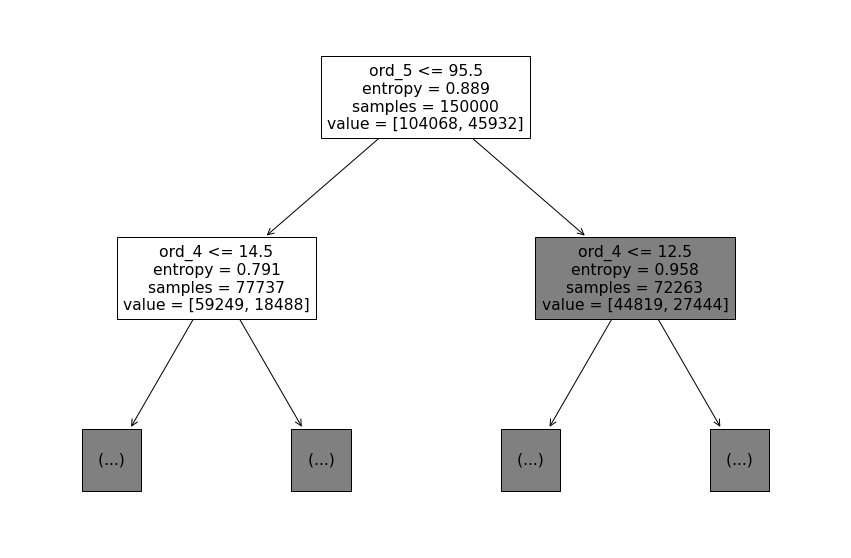

In [17]:
plt.figure(figsize=(15,10))
plot_tree(model_full, feature_names = df_train_processed1.columns, max_depth=1)
plt.show()

In [29]:
"""Let's submit"""


df_test_processed = process_features(df_test)

del df_test_processed["id"]

y_pred = [x[1] for x in model_full.predict_proba(df_test_processed)]


submission_full = pd.read_csv("data/competition_data/sample_submission.csv")

y_pred

submission_full["target"] = y_pred

submission_full

submission_full.to_csv("data/submissions/submission_full_features1.csv", header=True, index=False)

In [30]:
"""kaggle score: 0.69564"""

'kaggle score: 0.69564'